In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install split-folders

In [4]:
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/data_mfcc/data/', output="/content/gdrive/MyDrive/data_mcfcc/split_data/", seed=1, ratio=(.6, .2, .2)) # splitting 60-20-20

Copying files: 1445 files [10:50,  2.22 files/s]


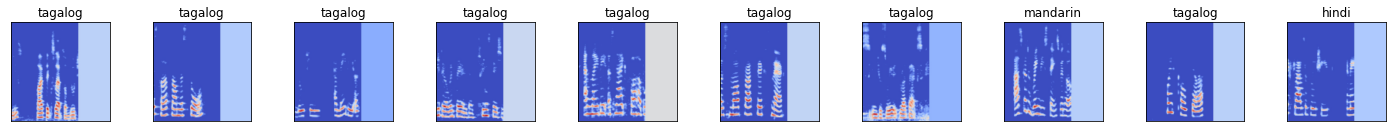

In [31]:
# Loading data from drive

import torch
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt


# location on Google Drive
master_path = '/content/gdrive/My Drive/data_mcfcc/split_data'

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])


# Load data from Google Drive
trainset = torchvision.datasets.ImageFolder(master_path + '/train', transform=transform)
valset = torchvision.datasets.ImageFolder(master_path + '/val', transform=transform)
testset = torchvision.datasets.ImageFolder(master_path + '/test', transform=transform)

# Prepare Dataloader
batch_size = 32
num_workers = 1
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['english', 'hindi', 'mandarin', 'tagalog']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [59]:
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 1
    j = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
        j = 1
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (j + 1)
    return err, loss

def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [19]:
def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('english', 'hindi', 'mandarin', 'tagalog')

    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    
    trainset = torchvision.datasets.ImageFolder(master_path + '/train', transform=transform)
    valset = torchvision.datasets.ImageFolder(master_path + '/val', transform=transform)
    testset = torchvision.datasets.ImageFolder(master_path + '/test', transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    #################
    # TODO: FIX THIS
    testset = torchvision.datasets.ImageFolder(master_path + '/test', transform=transform)
    
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

In [20]:
class ANN_Net(nn.Module):
    def __init__(self):
        super(ANN_Net, self).__init__()
        self.name = "net"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [21]:
net = ANN_Net()

In [55]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=10):
    ########################################################################
    # Train a classifier on accents
    target_classes = ["english", "mandarin", "hindi", "tagalog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 1
        j = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
            j = i
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (j+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
            
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [49]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [36]:
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.numpy() 
    classes = ['english', 'hindi', 'mandarin', 'tagalog']

    for i in np.arange(len(dataset)):
        # Check if the label is in the target classes
        #label_index = dataset[i][1]
        label_class = dataset[i][-1]
        if label_class in target_classes:
            indices.append(i)
    return indices

In [ ]:
for i in range(len(trainset)):
        # Check if the label is in the target classes
        print(trainset[i][-1])

In [34]:
i = 0
for param in net.parameters():
    print(param.shape)
    i = i + param.nelement()
print("")

print("net has", i, " parameters")

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])

net has 9705  parameters


In [60]:
train_net(net, batch_size = 64, learning_rate = 0.01, num_epochs = 10)

Epoch 1: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 2: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 3: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 4: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 5: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 6: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 7: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 8: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 9: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Epoch 10: Train err: 0.0, Train loss: 0.0 |Validation err: 0.0, Validation loss: 0.0
Finished Training


In [61]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [62]:
val_loader = torch.utils.data.DataLoader(valset_overfit, batch_size=9, 
                                           num_workers=num_workers, shuffle=False)

trainset_overfit = torchvision.datasets.ImageFolder('/content/gdrive/My Drive/APS360/Lab 3/Lab 3 Data/Split Data 2c/train', transform=transform)
valset_overfit = torchvision.datasets.ImageFolder('/content/gdrive/My Drive/APS360/Lab 3/Lab 3 Data/Split Data 2c/val', transform=transform)
train_loader = torch.utils.data.DataLoader(trainset_overfit, batch_size=18, 
                                           num_workers=num_workers, shuffle=False)

train_dataiter = iter(train_loader)
train_img, train_label = train_dataiter.next()
train_features = alexnet.features(train_img)

val_dataiter = iter(val_loader)
val_img, val_label = val_dataiter.next()
val_features = alexnet.features(val_img)

test_dataiter = iter(test_loader)
test_img, test_label = test_dataiter.next()
test_features = alexnet.features(test_img)

print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

train_path1 = 'train_path'
val_path1 = 'val_path'
test_path1 = 'test_path'

NameError: ignored

In [64]:
test_loader.dataset

NameError: ignored

In [ ]:
import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

batch_size = 1
num_workers = 1
train_loader1 = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader1 = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader1 = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

classes = ['english', 'hindi', 'mandarin', 'tagalog' ]

# save features to folder as tensors
a = 0
for img, label in train_loader1:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = train_path1 + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(a) + '.tensor')
  a += 1

b = 0
for img, label in val_loader1:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = val_path1 + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(b) + '.tensor')
  b += 1

c = 0
for img, label in test_loader1:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  folder_name = test_path1 + '/' + str(classes[label])
  if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
  torch.save(features_tensor.squeeze(0), folder_name + '/' + str(c) + '.tensor')
  c += 1

In [ ]:
feature_train_set = torchvision.datasets.DatasetFolder(train_path1, loader=torch.load, extensions=('.tensor'))
feature_val_set = torchvision.datasets.DatasetFolder(val_path1, loader=torch.load, extensions=('.tensor'))
feature_test_set = torchvision.datasets.DatasetFolder(test_path1, loader=torch.load, extensions=('.tensor'))

batch_size = 32
num_workers = 1
feature_train_loader = torch.utils.data.DataLoader(feature_train_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
feature_val_loader = torch.utils.data.DataLoader(feature_val_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
feature_test_loader = torch.utils.data.DataLoader(feature_test_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

# Verification Step - obtain one batch of features
dataiter = iter(feature_train_loader)
feature, label = dataiter.next()
print(feature.shape)
print(label.shape)

In [ ]:
nnet = ANN_Net()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  nnet = nnet.cuda()
  print('Training on GPU ...')
t_acc, v_acc = train(nnet7, feature_train_loader, feature_val_loader, batch_size=20, num_epochs=10, learn_rate = 0.001)